In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import models
from torch.autograd import Function
from torch.autograd import Variable
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [4]:
%cd 'drive/My Drive/ACV Project/'

/content/drive/.shortcut-targets-by-id/1-uBPm49Eo3uaCU1aA2S0UwaL0_iMXQKS/ACV Project


In [5]:
dim = 64
X = np.load(f'./Dataset-{dim}/TR-Image.npy')
y = np.load(f'./Dataset-{dim}/TR-Mask.npy')

X_test = np.load(f'./Dataset-{dim}/TE-Image.npy')
y_test = np.load(f'./Dataset-{dim}/TE-Mask.npy')

In [6]:
print(y.max(), y.min(), np.unique(y))

1 0 [0 1]


In [7]:
print(X.shape, X.dtype, X.max(), X.min())

(10553, 64, 64, 3) uint8 255 0


In [8]:
num_train = int(len(X) * 0.8)

p = np.random.permutation(len(X))
X = X[p]
y = y[p]

X_train, X_val = X[ : num_train], X[num_train : ]
y_train, y_val = y[ : num_train], y[num_train : ]

In [9]:
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(8442, 64, 64, 3) (2111, 64, 64, 3)
(8442, 64, 64) (2111, 64, 64)


In [10]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.transform = transform
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img, lab = self.images[idx], self.labels[idx]
        if self.transform:
            img = self.transform(img).type(torch.FloatTensor)
        
        lab = torch.from_numpy(lab).type(torch.LongTensor)
        return (img, lab)

In [11]:
transform = transforms.Compose(
    [
     transforms.ToTensor(),
    ]
)

In [12]:
train_set = CustomDataset(X_train, y_train, transform=transform)
val_set = CustomDataset(X_val, y_val, transform=transform)
test_set = CustomDataset(X_test, y_test, transform=transform)

In [13]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

In [14]:
itr = iter(train_loader)
img, lab = next(itr)

print(img.size(), lab.size())
print(img.type(), lab.type())

torch.Size([32, 3, 64, 64]) torch.Size([32, 64, 64])
torch.FloatTensor torch.LongTensor


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # 64x64
        self.conv1 = nn.Conv2d(3, 64, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        #32x32
        self.conv3 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.drop1 = nn.Dropout()

        #16x16
        self.conv5 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.drop2 = nn.Dropout()

        #8x8
        self.conv7 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn7 = nn.BatchNorm2d(128)
        self.conv8 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn8 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.drop3 = nn.Dropout()

        #4x4
        self.upconv1 = nn.ConvTranspose2d(128, 128, kernel_size = 2, stride = 2)
        self.bn9 = nn.BatchNorm2d(128)

        #8x8
        self.upconv2 = nn.ConvTranspose2d(128, 128, kernel_size = 2, stride = 2)
        self.bn10 = nn.BatchNorm2d(128)
        #16x16
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.bn11 = nn.BatchNorm2d(64)
        #32x32
        self.upconv4 = nn.ConvTranspose2d(64, 2, kernel_size = 2, stride = 2)
        #64x64

        self.upscore1 = nn.Upsample(scale_factor=16,mode='bilinear')
        self.upscore2 = nn.Upsample(scale_factor=8,mode='bilinear')
        self.upscore3 = nn.Upsample(scale_factor=4,mode='bilinear')
        self.upscore4 = nn.Upsample(scale_factor=2,mode='bilinear')

        self.outconv1 = nn.Conv2d(128,2,3,padding=1)
        self.outconv2 = nn.Conv2d(128,2,3,padding=1)
        self.outconv3 = nn.Conv2d(128,2,3,padding=1)
        self.outconv4 = nn.Conv2d(64,2,3,padding=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x1 = self.pool1(x)
        

        x = F.relu(self.bn3(self.conv3(x1)))
        x = F.relu(self.bn4(self.conv4(x)))
        x2 = self.pool2(x)
        x = self.drop1(x2)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x3 = self.pool3(x)

        x = F.relu(self.bn7(self.conv7(x3)))
        x = F.relu(self.bn8(self.conv8(x)))
        x4 = self.pool4(x)

        x5 = F.relu(self.bn9(self.upconv1(self.drop3(x4))))
        x6 = F.relu(self.bn10(self.upconv2(self.drop2(x5 + x3))))
        x7 = F.relu(self.bn11(self.upconv3(x6 + x2)))
        x8 = self.upconv4(x7 + x1)

        return self.upscore1(self.outconv1(x4)), self.upscore2(self.outconv2(x5)), self.upscore3(self.outconv3(x6)), self.upscore4(self.outconv4(x7)), x8

In [17]:
class RefineNet(nn.Module):

    def __init__(self):
        super(RefineNet, self).__init__()

        # 64x64
        self.conv1 = nn.Conv2d(2, 64, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        #32x32
        self.conv2 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        #16x16
        self.conv3 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        #8x8
        self.upconv1 = nn.ConvTranspose2d(128, 128, kernel_size = 2, stride = 2)
        self.bn4 = nn.BatchNorm2d(128)

        #16x16
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.bn5 = nn.BatchNorm2d(64)
        #32x32
        self.upconv3 = nn.ConvTranspose2d(64, 2, kernel_size = 2, stride = 2)
        #64x64

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = F.relu(self.bn4(self.upconv1(x)))
        x = F.relu(self.bn5(self.upconv2(x)))
        x = self.upconv3(x)

        return x

In [18]:
model = Net().to(device)
refine_model = RefineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
refine_optimizer = optim.Adam(refine_model.parameters())

In [19]:
def gaussian(window_size, sigma):
    gauss = torch.Tensor([np.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)

            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)

            self.window = window
            self.channel = channel

        img3 = torch.zeros(img2.size(0), 2, img2.size(1), img2.size(2))
        img3[:,1,:,:] = img2
        img3[:,0,:,:] = torch.max(img2) - img2
        # img2 = img3

        return _ssim(img1, img3.to(device), window, self.window_size, channel, self.size_average)

In [20]:
ssim_loss = SSIM(window_size=11,size_average=True)

In [21]:
def IoULoss(predicted, ground_truth):

    intersect = (predicted * ground_truth).sum((1, 2))
    union = (predicted + ground_truth).clamp(0, 1).sum((1, 2))

    return (1 - (intersect / union)).mean()

In [22]:
def train(model, refine_model, train_loader):
    model.train()
    refine_model.train()
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        refine_optimizer.zero_grad()

        outputs1, outputs2, outputs3, outputs4, outputs5 = model(inputs)

        loss1 = criterion(outputs1, labels) + IoULoss(outputs1.max(dim=1)[1], labels) + 1 - ssim_loss(outputs1, labels)
        loss2 = criterion(outputs2, labels) + IoULoss(outputs2.max(dim=1)[1], labels) + 1 - ssim_loss(outputs2, labels)
        loss3 = criterion(outputs3, labels) + IoULoss(outputs3.max(dim=1)[1], labels) + 1 - ssim_loss(outputs3, labels)
        loss4 = criterion(outputs4, labels) + IoULoss(outputs4.max(dim=1)[1], labels) + 1 - ssim_loss(outputs4, labels)
        loss5 = criterion(outputs5, labels) + IoULoss(outputs5.max(dim=1)[1], labels) + 1 - ssim_loss(outputs5, labels)
        
        outputs6 = refine_model(outputs5)
        
        loss6 = criterion(outputs6, labels) + IoULoss(outputs6.max(dim=1)[1], labels) + 1 - ssim_loss(outputs6, labels)
        
        loss = loss1 + loss2 + loss3 + loss4 + loss5 + loss6

        running_loss += loss.item()
        loss.backward()
        refine_optimizer.step()
        optimizer.step()

        if i % 50 == 49:
            print(f'Iteration {i + 1:5} | { (running_loss / 50):.5f}')
            running_loss = 0.0


In [23]:
def accuracy(model, refine_model, dataloader):
    model.eval()
    refine_model.eval()

    correct = 0
    total = 0
    iters = 0
    running_loss = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            _,_,_,_,outputs = model(images)
            outputs = refine_model(outputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += (labels.size(0) * labels.size(1) * labels.size(2))
            correct += (predicted == labels).sum().item()
            iters += 1

    print('Accuracy of the network on the images: %.3f %%' % (100 * correct / total))
    return (running_loss / iters), (100 * correct / total)

In [24]:
def mIoU(model, refine_model, dataloader, n_classes):
    model.eval()
    refine_model.eval()

    intersection = [0 for i in range(n_classes)]
    union = [0 for i in range(n_classes)]

    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            _,_,_,_,outputs = model(images)
            outputs = refine_model(outputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(n_classes):
                intersect = torch.mul(predicted==i, labels==i).sum().item()
                uni = torch.add(predicted==i, labels==i).sum().item()
                intersection[i] += intersect
                union[i] += uni

    iou = [0 for i in range(n_classes)]
    for i in range(n_classes):
        iou[i] = intersection[i] / union[i]
    
    return sum(iou) / len(iou)

In [ ]:
# start = 0
# epochs = 100
# train_acc = []
# train_loss = []
# val_acc = []
# val_loss = []

# for epoch in range(start, start + epochs):
#     print(f'Epoch {epoch + 1} started')
#     train(model, refine_model, train_loader)

#     print('IOU Train', mIoU(model, refine_model, train_loader, 2))
#     print('IOU val', mIoU(model, refine_model, val_loader, 2))

#     loss, acc = accuracy(model, refine_model, train_loader)
#     train_acc.append(acc)
#     train_loss.append(loss)
#     loss, acc = accuracy(model, refine_model, val_loader)
#     val_acc.append(acc)
#     val_loss.append(loss)

#     PATH = './CustomNet-64-v5-refinenet-extra-depth-ssim/' + str(epoch + 1)
#     torch.save(model, PATH)

#     PATH += '-checkpoint'
#     torch.save({
#         'epoch': epoch+1,
#         'model-state-dict': model.state_dict(),
#         'refine_model-state-dict': refine_model.state_dict(),
#         'refinemodel-state-dict': refine_model.state_dict(),
#         'train_acc': train_acc,
#         'train_loss': train_loss,
#         'val_acc': val_acc,
#         'val_loss': val_loss
#     }, PATH)

Epoch 1 started


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Iteration    50 | 11.67834
Iteration   100 | 9.96707
Iteration   150 | 9.53965
Iteration   200 | 9.18867
Iteration   250 | 8.95810
IOU Train 0.7298487261098541
IOU val 0.7242321633328572
Accuracy of the network on the images: 86.818 %
Accuracy of the network on the images: 86.517 %
Epoch 2 started
Iteration    50 | 8.66275
Iteration   100 | 8.54929
Iteration   150 | 8.41383
Iteration   200 | 8.35683
Iteration   250 | 8.16972
IOU Train 0.7598584192971538
IOU val 0.7498487458500396
Accuracy of the network on the images: 89.345 %
Accuracy of the network on the images: 88.880 %
Epoch 3 started
Iteration    50 | 8.08349
Iteration   100 | 8.09217
Iteration   150 | 7.96915
Iteration   200 | 7.90492
Iteration   250 | 7.94812
IOU Train 0.7991634174493532
IOU val 0.7854973182953546
Accuracy of the network on the images: 90.792 %
Accuracy of the network on the images: 90.095 %
Epoch 4 started
Iteration    50 | 7.80643
Iteration   100 | 7.77360
Iteration   150 | 7.71532
Iteration   200 | 7.67444
I

In [32]:
PATH = './CustomNet-64-v5-refinenet-extra-depth-ssim/100-checkpoint'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model-state-dict'])
refine_model.load_state_dict(checkpoint['refine_model-state-dict'])

<All keys matched successfully>

In [28]:
np.argmax(np.array(checkpoint['val_acc']))

73

In [30]:
accuracy(model, refine_model, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Accuracy of the network on the images: 90.303 %


(0.2911970421766779, 90.30299607584928)

In [31]:
mIoU(model, refine_model, test_loader, 2)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.7065003379419779

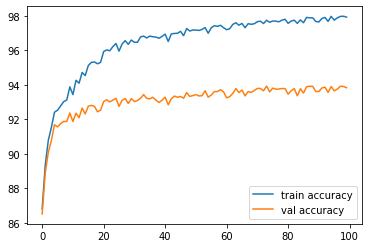

In [26]:
train_acc = checkpoint['train_acc']
train_loss = checkpoint['train_loss']
val_acc = checkpoint['val_acc']
val_loss = checkpoint['val_loss']

plt.plot(list(range(checkpoint['epoch'])), train_acc)
plt.plot(list(range(checkpoint['epoch'])), val_acc)
plt.legend(['train accuracy', 'val accuracy'], loc='lower right')
plt.show()

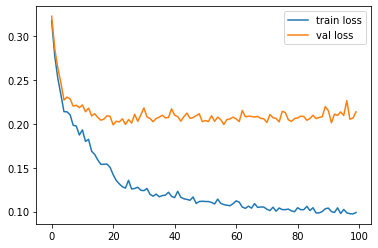

In [27]:
plt.plot(list(range(checkpoint['epoch'])), train_loss)
plt.plot(list(range(checkpoint['epoch'])), val_loss)
plt.legend(['train loss', 'val loss'], loc='upper right')
plt.show()

In [33]:
colors = [
    np.array([0,0,0], dtype=np.uint8),
    np.array([255,255,255], dtype=np.uint8),
]

In [34]:
itr = iter(test_loader)

torch.Size([3, 64, 64]) | torch.Size([64, 64]) | torch.Size([64, 64])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([3, 64, 64]) | torch.Size([64, 64]) | torch.Size([64, 64])
(64, 64, 3)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


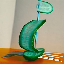

In [50]:
model.eval()
img, lab = itr.next()
_,_,_,_,outputs = model(img.to(device))
outputs = refine_model(outputs)
_,predicted = torch.max(outputs, 1)

input, lab, pred = img[0], lab[0], predicted[0].cpu().detach()
print(f'{input.size()} | {lab.size()} | {pred.size()}')

img_size = input.shape[-1]
input_img = np.zeros((img_size, img_size, 3))
input_img[:, :, 0] = input[0]
input_img[:, :, 1] = input[1]
input_img[:, :, 2] = input[2]

input_img = (255 * input_img)
print(input_img.shape)
input_img = Image.fromarray(input_img.astype('uint8'), mode='RGB')
ground_truth = np.zeros((img_size, img_size, 3), dtype=np.uint8)
predicted = np.zeros((img_size, img_size, 3), dtype=np.uint8)

for i in range(img_size):
    for j in range(img_size):
        ground_truth[i][j] = colors[lab[i][j]]
        predicted[i][j] = colors[pred[i][j]]

ground_truth = Image.fromarray(ground_truth).convert('RGB')
predicted = Image.fromarray(predicted).convert('RGB')

display(input_img)

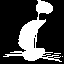

In [51]:
display(ground_truth)

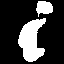

In [52]:
display(predicted)

In [ ]:
def get_image_predictions(img_path, model, refine_mode):
    colors = [
        np.array([0,0,0], dtype=np.uint8),
        np.array([255,255,255], dtype=np.uint8),
    ]

    model.eval()
    refine_model.eval()

    img = Image.open(img_path).resize((256, 256))
    img = np.array(img).transpose(2, 0, 1)

    img = torch.from_numpy(img.astype(np.float32)/255).to(device).unsqueeze(0)
    _,_,_,_,output = model(img)
    output = refine_model(output)
    _,pred = torch.max(output, 1)
    pred = pred[0].cpu().detach()

    img_size = pred.size(0)
    predicted = np.zeros((img_size, img_size, 3), dtype=np.uint8)

    for i in range(img_size):
        for j in range(img_size):
            predicted[i][j] = colors[pred[i][j]]
    
    predicted = Image.fromarray(predicted).convert('RGB')

    return predicted

In [ ]:
prediction = get_image_predictions('./test_images/16.jpg', model, refine_model)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


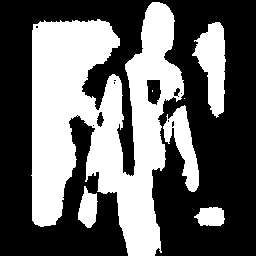

In [ ]:
display(prediction)